number of states:  16
[[ 0.   -2.   -2.    0.    0.   -2.    0.    0.    0.    0.   -2.    0.
   0.    0.    0.    0.  ]
 [-2.    1.5   0.    1.    1.    0.    0.    0.    0.    0.    0.   -2.
   0.    0.    0.    0.  ]
 [-2.    0.    1.5   1.    0.    0.    0.    1.    1.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    1.    1.    2.25  0.    0.    1.    0.    0.    1.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    2.25  1.    1.    0.    0.    0.    0.    0.
   0.    0.    1.    0.  ]
 [-2.    0.    0.    0.    1.    1.5   0.    1.    0.    0.    0.    0.
   0.    0.    0.    1.  ]
 [ 0.    0.    0.    1.    1.    0.    3.    1.    0.    0.    0.    0.
   1.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    1.    1.    3.    0.    0.    0.    0.
   0.    1.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    2.25  1.    1.    0.
   0.    1.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    1.    3.    0.   -0.5
   1.    0.   

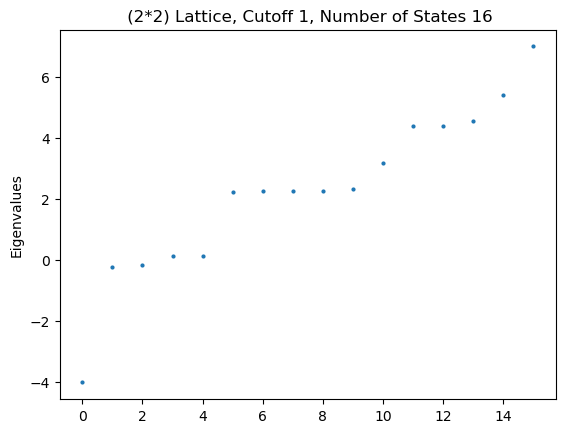

In [1]:
#closed boundary condition
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
def part_dia_hamiltonian(st_cut,n,x,y): 
    """The purpose of this function is to make the diagonal hamiltonian strand wise, then sum the individual value with the next strand possible by calling the function again and summing"""
    ham=[]
    ls=len(st_cut)
    for i in range(0,ls):
        part=0
        for j in range(0,len(st_cut[i])):                
            if n==0:
                if j%2==1:
                    if j==len(st_cut[i])-1:
                        part=part+0.5*(st_cut[i][j][2]+st_cut[i][j][0])*((0.5*(st_cut[i][j][2]+st_cut[i][j][0]))+1)
                    else:
                        part=part+(0.5*(st_cut[i][j][0]+st_cut[i][j][1]))*((0.5*(st_cut[i][j][0]+st_cut[i][j][1]))+1) + (0.5*(st_cut[i][j][0]+st_cut[i][j][2]))*((0.5*(st_cut[i][j][0]+st_cut[i][j][2]))+1)
                if j%2==0:
                    if j!=0:
                        part=part+(0.5*(st_cut[i][j][0]+st_cut[i][j][1]))*((0.5*(st_cut[i][j][0]+st_cut[i][j][1]))+1)
            elif n==x:
                if j%2==0:
                    if j==0:
                        part=part+(0.5*(st_cut[i][j][2]+st_cut[i][j][0]))*((0.5*(st_cut[i][j][2]+st_cut[i][j][0]))+1)
                    else:
                        part=part+(0.5*(st_cut[i][j][0]+st_cut[i][j][1]))*((0.5*(st_cut[i][j][0]+st_cut[i][j][1]))+1) + (0.5*(st_cut[i][j][0]+st_cut[i][j][2]))*((0.5*(st_cut[i][j][0]+st_cut[i][j][2]))+1)
                if j%2==1:
                    if j!=len(st_cut[i])-1:
                        part=part+(0.5*(st_cut[i][j][0]+st_cut[i][j][1]))*((0.5*(st_cut[i][j][0]+st_cut[i][j][1]))+1)
            else:
                if j==0 or j==len(st_cut[i])-1:
                    part=part+(0.5*(st_cut[i][j][0]+st_cut[i][j][2]))*((0.5*(st_cut[i][j][0]+st_cut[i][j][2]))+1) 
                else:
                    part=part+(0.5*(st_cut[i][j][0]+st_cut[i][j][1]))*((0.5*(st_cut[i][j][0]+st_cut[i][j][1]))+1) + (0.5*(st_cut[i][j][0]+st_cut[i][j][2]))*((0.5*(st_cut[i][j][0]+st_cut[i][j][2]))+1)
        ham.append(copy.deepcopy(part)) 
    return (ham)

def discrete_local_h_space(cut):  
    """1. This function is making all possible three leg vertex possible upto the given cut off if no condition except the condition cutoff is introduced, and storing it to local_h_space "local_h_space"."""
    local_h_space=[]
    for i in range(0,cut+1):
        for j in range(0,cut+1):
            for k in range(0,cut+1):
                if i+j<=cut and j+k<=cut and k+i<=cut:
                    local_h_space.append(copy.deepcopy([i,j,k]))
    return (local_h_space)
def strand_stiching(x,y,local_h_space,cut):
    """The purpose of this function is to make the whole lattice, by stiching all the AGL satisfied strands
    1.First it is calling the "one_strand" function, which gives the AGL states of a strand 
    2.Then it is extracting out all the flux going to the upper strand for corresponding lattice points for all strands in st, and storing it in bc1 as boundary condition
    3.Then given a boundary condition (Which are bacically AGL between two strings) it is calling the the "one_strand" function again which creats the next set of strand.
    4.Doing this (n+1) times will make the whole (n*n) lattice
    5. storing mechanism is exactly same written for stiching function
    """

    def one_strand(x,y,local_h_space,bc1,n,cut):
        """ 
        1. A (s*s) lattice has s+1 sites in one string. Since it is point splited lattice every point is spilited into two sites so, total 2(s+1)sites
        2.This function is first calling "stc" which gives the possiblle vertex for the first site in that strand. 
        3.Then it is calling stiching function 2s+1 times. Where s is the dimension of the lattice.
        And that makes a full string containing AGL satisfied states of 2(s+1) sites """
        def stc(local_h_space,ll,bc1,n,cut): 
            """This function is making the first site three leg states for every strand, and storing it is st
            and gets ready to be acted by the stiching function to make the whole strand"""
            st=[]

            for i in range(0,ll):
                if n==0 and local_h_space[i][0]==0 and local_h_space[i][1]+local_h_space[i][2]==0:
                    st.append(copy.deepcopy([local_h_space[i]]))

                if n!=0 and local_h_space[i][0]+local_h_space[i][2]==bc1[0] and local_h_space[i][1]+local_h_space[i][2]<=cut and local_h_space[i][0]+local_h_space[i][1]==0:# bc[1] is changed into bc[0]
                    st.append(copy.deepcopy([local_h_space[i]]))
            return (st) 
        #End of stc
    
        def stiching(x,y,local_h_space,st,bc1,ls1,m,n,cut):
            """
            1.This function is stiching every three leg vertex to the next three leg vertex with Abelien Gauss Law
            2.Conditions are given specific to the end points AGL and AGL inside the bulk
            3.For given elements in "st" a three leg vertex of a site it is first checking what are the possible three point vertex could be for the next site from elements of "local_h_space", which is all possible 3-leg discrete vertex upto cutoff
                (i)so if the element of st was "!" for first site and next site's AGL satisfied elements are @,#,$ given first site has "!", it is storing @,#,$ in local_h_space1
                (ii) In temporary1 variable it is copying "!"
                (iii) The loop changes temporary to [!,@] [!,#] [!,$] in repective runs and storing it to st
                (iv)So "st" will have elements [!,[!,@],[!,#],[!,$]] ,Then pop is removing the zeroth element
                (v)So, "st" will have elements [[!,@],[!,#],[!,$]]. Which is all possible AGL satisfied states upto 2 sits
            4. These same set of things it is doing for all the adjacent sites upto one strand by calling this function again and again
            """
            """
            1. "local_h_space" is the possible nunber of three point vertex permissible through boundary condition on quantum numbers.
            2. "st" is the dynamic variable in function definition it has to comes first as states upto first link permisible by the boundary condition. 
                then it change to 2nd 3rd so on
            3. "bc1" is the boundary conditions available for one strand
            4. "ls1" is the number of states in st 
            5. "ll" is the number of discrete three point vertex 
            """

            local_h_space1=[]
            ll=len(local_h_space)
            ls1=len(st)
            for i in range(0,ls1):#i goes over the number of instantenous element presents in the st, with every iteration this value changes
                local_h_space1.clear()
                for j in range(0,ll):#j goes over all posssible 3 point vertex upto specified cutoff
                    l0=len(st[0]) # l0=m? (yes)
                    if n==0 and l0%2==0 and st[0][l0-1][0]+st[0][l0-1][1]==local_h_space[j][0]+local_h_space[j][1] and local_h_space[j][0]+local_h_space[j][2]==0:
                        local_h_space1.append(copy.deepcopy(local_h_space[j]))
                    #if n==0 and l0==2*y+1 and st[0][l0-1][0]+st[0][l0-1][1]==local_h_space[j][0]+local_h_space[j][1] and local_h_space[j][0]+local_h_space[j][2]==0:
                        #local_h_space1.append(copy.deepcopy(local_h_space[j]))
                    if n!=0 and l0%2==0 and st[0][l0-1][0]+st[0][l0-1][1]==local_h_space[j][0]+local_h_space[j][1] and local_h_space[j][0]+local_h_space[j][2]==bc1[(l0//2)]:
                        local_h_space1.append(copy.deepcopy(local_h_space[j]))
                    if n!=x and l0!=2*y+1 and l0%2==1 and st[0][l0-1][1]+st[0][l0-1][2]==local_h_space[j][1]+local_h_space[j][2]:
                        local_h_space1.append(copy.deepcopy(local_h_space[j]))
                    if n!=x and l0==2*y+1 and l0%2==1 and st[0][l0-1][1]+st[0][l0-1][2]==local_h_space[j][1]+local_h_space[j][2] and local_h_space[j][0]+local_h_space[j][1]==0:
                        local_h_space1.append(copy.deepcopy(local_h_space[j])) 
                    if n==x and l0!=2*y+1 and l0%2==1:
                        if st[0][l0-1][1]+st[0][l0-1][2]==local_h_space[j][1]+local_h_space[j][2] and local_h_space[j][0]+local_h_space[j][2]==0:
                            local_h_space1.append(copy.deepcopy(local_h_space[j]))
                    if n==x and l0==2*y+1 and l0%2==1:
                        if st[0][l0-1][1]+st[0][l0-1][2]==local_h_space[j][1]+local_h_space[j][2]and local_h_space[j][0]==0 and local_h_space[j][1]+local_h_space[j][2]==0 and local_h_space[j][0]+local_h_space[j][2]==0:
                            local_h_space1.append(copy.deepcopy(local_h_space[j]))
                #print(local_h_space1)
                for k in local_h_space1:
                    temporary1 = copy.deepcopy(st[0])
                    temporary1.append(k)
                    st.append(copy.deepcopy(temporary1))
                st.pop(0) 
            # print(st)
            return(st) 
        #End of stiching

   
        ll=len(local_h_space)
        st=stc(local_h_space,ll,bc1,n,cut)         
        for m in range(0,2*y+1):# m runs over the lattice, basically if we cange the number of m to 3 it will make all possible 3 site states that obeys AGL
            l1=len(st)
            st= stiching(x,y,local_h_space,st,bc1,len(st),m,n,cut)
            l1=len(st)
        return (st)
    #End of one_strand


    st_cut=[]
    bc1=[]
    ham=[]
    for n in range(0,x):
        if n==0:
            st=one_strand(x,y,local_h_space,bc1,n,cut)        
        lst1=len(st)
        inbc1=[] 
        temporary_state1=[]                   #correct
        st_cut.clear()
        for i in range(0,lst1):
            st_cut.append(st[i][-(2*y+2):].copy())
        if n==0:
            ham=part_dia_hamiltonian(st_cut,n,x,y)
        bc1.clear()
        for i in range(0,lst1):
            inbc1.clear()
            for j in range(0,2*y+2):
                if j%2==1:
                    inbc1.append(st_cut[i][j][0]+st_cut[i][j][2])
            # if n==s-1:
            #     for p in range(0,s+1):                    #This part is for some other boundary condition 
            #         inbc1.append(bc[3*s+3-p])   
            bc1.append(inbc1.copy())
        lb=len(bc1)

        for i in range(0,lb):
            nst=one_strand(x,y,local_h_space,bc1[0],n+1,cut)
            
            nham=part_dia_hamiltonian(nst,n+1,x,y)
            
            for j in range(0,len(nst)):
                ham.append(ham[0]+nham[j])
                temporary_state1=st[0].copy()
                for k in range(0,2*y+2):
                    temporary_state1.append(nst[j][k])
                st.append(temporary_state1)
                
                
            
            st.pop(0)
            bc1.pop(0)
            ham.pop(0) 
  
    return (st,ham)


def total_hamiltonian(states,d_hamiltonian,x,y):
    """This function makes the offdiagonal hamiltonian first as ofdiham then makes the total hamiltonian as total_ham then returns the total hamiltonian """
    states1=[]
    import copy
    for i in states:
        states_element=copy.deepcopy(i)                 #This part can be erased if it is made sure that everything done previously is properly deep copied. so that value of a variables isn't linked with other variables. And then everything else can be carried out with "states" instead of "states1" (Shallow copy problem)
        states1.append(states_element)


    """ This inter consists of besically the operators that changes the states ofthe hilbert space"""
    con=[]
    inter=[]
    inter_m=[]
    for i in range(0,2):
        for j in range(0,2):
            con.append([i,j])
            inter.append([[i,j]])
    for p in range(0,5):
        li=len(inter)
        for i in range(0,li):
            inter_m.clear()
            for j in con:
                if p!=4 and inter[0][len(inter[0])-1][1]==j[0]:
                    inter_m.append(j)
                if p==4 and inter[0][len(inter[0])-1][1]==j[0] and inter[0][0][0]==j[1] :
                    inter_m.append(j)   
            for k in inter_m:
                inter_0=inter[0].copy()
                inter_0.append(k)
                inter.append(inter_0)
            inter.pop(0)

    import copy
    ofdiham=[]
    # d_ham=[]
    total_ham=[]
    arr=[]
    for i in range(0,len(states1)):
        arr.clear()
        for j in range(0,len(states1)):
            arr.append(0)
        arr1=copy.deepcopy(arr)
        ofdiham.append(copy.deepcopy(arr1))
        # d_ham.append(copy.deepcopy(arr1))
        total_ham.append(copy.deepcopy(arr1))
    
    """This is where the making of Offdiagolnal elements starts"""
    for i in range(0,len(states1)):
        import copy
        import math
        for lqn in range(1,x*y+1):   # lqn runs over all the loops over the lattice, besically it will run x*y times

            for j in range(0,len(inter)):

                eta=1;mf1=1;mf2=1;mf3=1;mf4=1
                instate= copy.deepcopy(states1[i])
                
                if inter[j][0]==[1,1]:
                        eta=eta*(-1)
                if inter[j][1]==[0,0]:
                        eta=eta*(-1)
                if inter[j][2]==[1,1]:
                        eta=eta*(-1)
                if inter[j][3]==[0,0]:
                        eta=eta*(-1)
                if inter[j][4]==[1,1]:
                        eta=eta*(-1)
                if inter[j][5]==[0,0]:
                        eta=eta*(-1)
                instate_copy = copy.deepcopy(instate)
                for k in range(0,6):
                    if k<=2:
                        p=(2*lqn)+2*((lqn-1)//y)-1+k
                    if k>2:
                        p=(2*y)+5+(2*lqn)+2*((lqn-1)//y)-k

                    lpq=0;lpr=0;lqr=0
                    if k==0 or k==3:
                        lpq=copy.deepcopy(instate[p][0])
                        lpr=copy.deepcopy(instate[p][2])
                        lqr=copy.deepcopy(instate[p][1])
                    if k==1 or k==4:
                        lpq=copy.deepcopy(instate[p][1])
                        lpr=copy.deepcopy(instate[p][0])
                        lqr=copy.deepcopy(instate[p][2])
                    if k==2 or k==5:
                        lpq=copy.deepcopy(instate[p][2])
                        lpr=copy.deepcopy(instate[p][1])
                        lqr=copy.deepcopy(instate[p][0])

                    if inter[j][k]==[0,0]:
                        if lpq+1>cut:
                            mf1=0
                            continue
                        mf1=mf1*math.sqrt((lpq+1)*(lpq+lqr+lpr+2))*math.sqrt(1/(lpq+lpr+1))
                        lpq=lpq+1

                        if k==0 or k==3:
                            instate_copy[p][0]=lpq
                        
                        if k==1 or k==4:
                            instate_copy[p][1]=lpq
                        
                        if k==2 or k==5:
                            instate_copy[p][2]=lpq
                        
                        mf1=mf1*math.sqrt(1/(lpq+lqr+1))


                    if inter[j][k]==[1,1]:
                        if lpq-1<0:
                            mf2=0
                            continue
                        mf2=mf2*math.sqrt(lpq*(lpq+lpr+lqr+1))*math.sqrt(1/(lpq+lpr+1))
                        lpq=lpq-1
                        if k==0 or k==3:
                            instate_copy[p][0]=lpq
                        if k==1 or k==4:
                            instate_copy[p][1]=lpq
                        if k==2 or k==5:
                            instate_copy[p][2]=lpq 
                        mf2=mf2*math.sqrt(1/(lpq+lqr+1))

                    if inter[j][k]==[0,1]:
                        if lpr+1>cut or lqr-1<0:
                            mf3=0
                            continue
                        mf3=mf3*math.sqrt((lpr+1)*lqr)*math.sqrt(1/(lpq+lpr+1))
                        lpr+=1
                        lqr-=1
                        if k==0 or k==3:
                            instate_copy[p][0]=lpq;instate_copy[p][2]=lpr;instate_copy[p][1]=lqr
                        if k==1 or k==4:
                            instate_copy[p][1]=lpq;instate_copy[p][0]=lpr;instate_copy[p][2]=lqr
                        if k==2 or k==5:
                            instate_copy[p][2]=lpq;instate_copy[p][1]=lpr;instate_copy[p][0]=lqr
                        mf3=mf3*math.sqrt(1/(lpq+lqr+1))

                    if inter[j][k]==[1,0]:
                        if lpr-1<0 or lqr+1>cut:
                            mf4=0
                            continue
                        mf4=mf4*math.sqrt(lpr*(lqr+1))*math.sqrt(1/(lpq+lpr+1))
                        lpr-=1
                        lqr+=1
                        if k==0 or k==3:
                            instate_copy[p][0]=lpq;instate_copy[p][2]=lpr;instate_copy[p][1]=lqr
                        if k==1 or k==4:
                            instate_copy[p][1]=lpq;instate_copy[p][0]=lpr;instate_copy[p][2]=lqr
                        if k==2 or k==5:
                            instate_copy[p][2]=lpq;instate_copy[p][1]=lpr;instate_copy[p][0]=lqr
                        mf4=mf4*math.sqrt(1/(lpq+lqr+1))

                instate=instate_copy #Here instate is the state after the action of the operators which changes the initial state states1[i]
                mf=mf1*mf2*mf3*mf4
                if instate==states1[i]:
                    mf=0
                    continue
                element=mf*eta #element is the numerical value of the offdiagonal element

                for u in range(0,len(states1)):
                    if states1[u]==instate: 
                        mcopy=copy.deepcopy(ofdiham[u][i])
                        ofdiham[u][i]=mcopy+element                           
    #print("Offdiaginal matrix of the hamiltonian")
    #print(np.array(ofdiham))   #Ofdiham consists of matrix elements with only the offdiagonal matrix elements of the hamiltonian
    g0= 1.0






    # print(d_hamiltonian)

    # for i in range (0,len(states1)):
    #     for j in range (0,len(states1)):
    #         if i==j:
    #             d_ham[j][j]=((g0*g0)/4)*d_hamiltonian[j]

    # for i in range(0,len(states)):
    #     print(d_ham[i][i])
    #print("Diagonal hamiltonian is ")            
    #print(np.array(d_ham))   #d_ham consists of the diagonal matrix elements of the hamiltonian 

    f=1
    """This part makes the total hamiltonian, Here the total hamitonian stands for (1/(g0*g0))*H """
    for i in range (0,len(states1)):
        for j in range (0,len(states1)):
            if i!=j:
                total_ham[i][j]=(1)*(1/(g0*g0*g0*g0))*(2*ofdiham[i][j]) # H_B = 2*ofdiham[i][j]  (as ofdiham[i][j] = Tr{U_plaqutte} and H_B=2*Tr{U_plaqutte}) 
            if i==j:
                total_ham[i][j]=ofdiham[i][j]+(1/4)*d_hamiltonian[j]
                
    return total_ham


    # print(type(total_ham))
    # print(len(total_ham))
    # print(len(total_ham[0]))


def find_degenerate_levels(evals, tol=1e-8):
    groups = []
    used = np.zeros(len(evals), dtype=bool)

    for i in range(len(evals)):
        if used[i]:
            continue
        group = [i]
        for j in range(i+1, len(evals)):
            if abs(evals[i] - evals[j]) < tol:
                group.append(j)
                used[j] = True
        if len(group) > 1:
            groups.append(group)
        used[i] = True
    return groups

def print_degenerate_states(groups, evals, evecs, states, amp_tol=1e-6):
    for g in groups:
        print("\n" + "="*80)
        print(f"Eigenvalue ≈ {evals[g[0]]:.10f}")
        print(f"Degeneracy = {len(g)}")
        for idx in g:
            print(f"\nEigenvector {idx}")
            for i, amp in enumerate(evecs[:, idx]):
                if abs(amp) > amp_tol:
                    print(f"Amplitude {amp:+.4f}")
                    print(f"State index {i}")
                    print(states[i])








x=2;y=2
cut=1



local_h_space=discrete_local_h_space(cut)
states, d_hamiltonian =strand_stiching(x,y,local_h_space,cut)
print("number of states: ",len(states))
# for i in range(0,len(states)):
#     print(states[i])
#print("Total hamiltonian is ")  
total_ham=total_hamiltonian(states,d_hamiltonian,x,y)          
#print(np.array(total_ham)) #total_ham is the full hamiltonian 
print(np.array(total_ham))


"""This part finds eigenvalues of the hamiltonian matrix """
# eigenvalues1 = np.linalg.eigvals(np.array(total_ham)) #This is the diagonalisation of the matrix. Besically the task is to find out the eigenvalues of the matrix
# eigenvalues_real = np.real(eigenvalues1)
print("number of states: ",len(states))
#print(eigenvalues_real)
eigenvalues_2, eigenvectors_2 = np.linalg.eigh(np.array(total_ham))




deg_groups = find_degenerate_levels(eigenvalues_2)

print("\n=========== Degenerate Energy Levels ===========\n")
for g in deg_groups:
    print(f"Energy ≈ {eigenvalues_2[g[0]]:.10f}, Degeneracy = {len(g)}")
print_degenerate_states(deg_groups, eigenvalues_2, eigenvectors_2, states)


#check if the degeneracy lifted :

# def reflection_operator(state, x, y):
#     """Return the reflected state along vertical axis for x*y lattice"""
#     state_ref = []
#     for row in state:
#         state_ref.append(list(reversed(row)))  # reverse columns in each row
#     return state_ref

# def build_reflection_breaking_subspace(states, x, y):
#     subspace = []
#     for s in states:
#         s_ref = reflection_operator(s, x, y)
#         if s != s_ref:  # only keep non-symmetric combinations
#             # subtract reflected to break symmetry
#             new_state = np.array(s) - np.array(s_ref)
#             subspace.append(new_state.tolist())
#     return subspace


# subspace_states = build_reflection_breaking_subspace(states, x, y)
# dim_sub = len(subspace_states)
# H_sub = np.zeros((dim_sub, dim_sub))

# for i, si in enumerate(subspace_states):
#     for j, sj in enumerate(subspace_states):
#         # Find indices in original states
#         idx_i = states.index(si) if si in states else None
#         idx_j = states.index(sj) if sj in states else None
#         if idx_i is not None and idx_j is not None:
#             H_sub[i,j] = total_ham[idx_i, idx_j]


# eigvals_sub, eigvecs_sub = np.linalg.eigh(H_sub)

# deg_groups_sub = find_degenerate_levels(eigvals_sub)
# print("\n=========== Reflection-breaking Degeneracies ===========\n")
# for g in deg_groups_sub:
#     print(f"Energy ≈ {eigvals_sub[g[0]]:.10f}, Degeneracy = {len(g)}")

# plt.plot(np.arange(len(eigvals_sub)), eigvals_sub, 'o', markersize=3)
# plt.ylabel("Eigenvalues (reflection-breaking)")
# plt.title(f"{x}x{y} lattice, cut={cut}, reflection-breaking subspace size={dim_sub}")
# plt.show()

# Eigenvalues are already sorted in ascending order in eigh()
# low_eigenvalue = eigenvalues_2[0]
# low_eigenvector = eigenvectors_2[:, 0]  # First column corresponds to lowest eigenvalue

# Print the lowest eigenvalue and its corresponding eigenvector
# print("Lowest eigenvalue:", low_eigenvalue)
# print("Corresponding eigenvector:", low_eigenvector)

# Optional: Print all eigenvalues
# print("All eigenvalues:", eigenvalues_2)
#print(eigenvalues_real[0])

# EV=eigenvectors_2
# EVT=np.transpose(eigenvectors_2)

# print(EV)
# Electric_E=[]
# Electric_E=np.matmul(EVT,np.matmul(d_ham,EV))
# print(Electric_E)
# print(np.diag(Electric_E))



"""This part is to scatter plot the eigenvalues"""
xaxis = np.arange(len(states))
plt.ylabel("Eigenvalues")
plt.title(f" ({x}*{y}) Lattice, Cutoff {cut}, Number of States {len(states)}")
plt.plot(xaxis , eigenvalues_2,'o',markersize=2)
plt.show()

#np.savetxt(f"/Users/photon/Downloads/my_projects_jl/su2_ir/eigenvalues_{x}x{y}_cut{cut}_g0{5.0}.txt", eigenvalues_2)
